# **Download the dataset**
首先先下載需要用到的資料，解壓縮後資料夾內的結構如下  
Training data 769張  
Testing data 166張  
總共有23個label(23種野生蘭花)
```
MLHW7_dataset/
|----train
    |----0_001.jpg
    |----0_002.jpg
      ...
    |----1_069.jpg
      ...
|----test
    |----0_001.jpg
    |----0_002.jpg
    ...
|----label_versus_Orchid_name.xlsx
``` 

In [5]:
!gdown --id 1NTLuuaM831zN6oL4a0EX4cjIephAEPIC --output "data.zip"
!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1NTLuuaM831zN6oL4a0EX4cjIephAEPIC
To: /content/data.zip
100% 1.60G/1.60G [00:10<00:00, 158MB/s]


# **Import Packages**

In [2]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import DatasetFolder
from torchvision.transforms import AutoAugmentPolicy
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import tensorflow as tf
import csv
import pandas as pd

### 固定 random seed

In [3]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(87)

# **Dataset, Data Loader, and Transforms**
Reference:  
https://blog.csdn.net/weixin_41469023/article/details/115375927  
https://www.itread01.com/content/1544541602.html 

In [6]:
class Orchid(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.filenames = []
        filenames = glob.glob(os.path.join(root,'*'))
        for fn in filenames:
            if root == 'MLHW7_dataset/train/':
              i = fn[20:]
              if i[1] == '_':
                i = i[:1]
              elif i[2] == '_':
                i = i[:2]
              elif i[3] == '_':
                i = i[:3]
            if root == 'MLHW7_dataset/test/':
              i = fn[19:]
              if i[1] == '_':
                i = i[:1]
              elif i[2] == '_':
                i = i[:2]
              elif i[3] == '_':
                i = i[:3]
            i = int(i)
            self.filenames.append((fn,i))
        self.len = len(self.filenames)
    def __getitem__(self, index):
        image_fn, label = self.filenames[index]
        image = Image.open(image_fn)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    def __len__(self):
        return self.len

## Data Augmentation
對現有圖片進行平移、翻轉、旋轉、改變明度對比度等方式來增加資料集

In [7]:
randomAugment = [transforms.ColorJitter(0.1, 0.1, 0.1), transforms.ColorJitter(0.2, 0.2, 0.2)]
autoAugment = [transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
         transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
         transforms.AutoAugment(policy=AutoAugmentPolicy.SVHN)]

train_tfm1 = transforms.Compose([
	transforms.Resize((1024, 1024)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.7),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm2 = transforms.Compose([
	transforms.Resize((1024, 1024)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
  transforms.RandomAffine(degrees=20, translate=(0.12, 0.12), scale=(0.8, 1.2)),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm3 = transforms.Compose([
	transforms.Resize((1024, 1024)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.7),
  transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
  transforms.RandomAffine(degrees=30, translate=(0.12, 0.12), scale=(0.8, 1.2)),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm4 = transforms.Compose([
	transforms.Resize((1024, 1024)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.8),
  transforms.AutoAugment(policy=AutoAugmentPolicy.SVHN),
  transforms.RandomAffine(degrees=15, translate=(0.12, 0.12), scale=(0.8, 1.2)),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm5 = transforms.Compose([
	transforms.Resize((1024, 1024)),
  transforms.RandomChoice(randomAugment),
  transforms.ColorJitter(0.3, 0.2, 0.15),
  transforms.RandomHorizontalFlip(p=0.6),
  transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfm = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Load Data
把所有資料包裝好之後載下來

In [8]:
# Construct datasets.
train_set1 = Orchid("MLHW7_dataset/train/", transform=train_tfm1)
train_set2 = Orchid("MLHW7_dataset/train/", transform=train_tfm2)
train_set3 = Orchid("MLHW7_dataset/train/", transform=train_tfm3)
train_set4 = Orchid("MLHW7_dataset/train/", transform=train_tfm4)
train_set5 = Orchid("MLHW7_dataset/train/", transform=train_tfm5)
train_set = ConcatDataset([train_set1, train_set2, train_set3, train_set4, train_set5])
validation_set = Orchid("MLHW7_dataset/test/", transform=test_tfm)

print('# images in trainset:', len(train_set)) 
print('# images in validationset:', len(validation_set))

# Construct data loaders.
batch_size = 4
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

# images in trainset: 3845
# images in validationset: 166
Image tensor in each batch: torch.Size([4, 3, 1024, 1024]) torch.float32
Label tensor in each batch: torch.Size([4]) torch.int64


看一下要train的圖片，確認做完data augmentation後的圖片合不合理

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:
tensor(2) tensor(2) tensor(16) tensor(21)


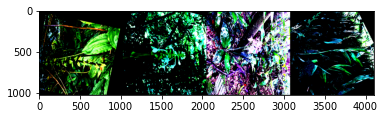

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(4)))

# **Model**

In [4]:
# 看一下哪一種GPU，不過現在免費版的只剩下超爛的K80
# 運氣好可以抽到Tesla T4
use_cuda = torch.cuda.is_available()
torch.manual_seed(87)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)
!nvidia-smi

Device used: cuda
Sun Jan 16 13:13:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                      

In [10]:
import torchvision.models as models 
model = models.efficientnet_b2(pretrained=True).to(device)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=23, bias=True),
    ).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [11]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

# **Training**

In [12]:
from tqdm.auto import tqdm

In [13]:
import torchvision.models as models
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
n_epochs = 7
best_acc = 0
# checkpoint = torch.load('drive/MyDrive/model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        # loss = checkpoint['loss']
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    model.eval()
    valid_loss = []
    valid_accs = []
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        with torch.no_grad():
          logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save({
          'optimizer_state_dict': optimizer.state_dict(),
          'model_state_dict': model.state_dict(),
          'loss': loss
          },'model.pt')
        print('model saved')

  0%|          | 0/962 [00:00<?, ?it/s]

[ Train | 001/007 ] loss = 2.00532, acc = 0.43061


  0%|          | 0/42 [00:00<?, ?it/s]

[ Valid | 001/007 ] loss = 0.84623, acc = 0.75595
model saved


  0%|          | 0/962 [00:00<?, ?it/s]

[ Train | 002/007 ] loss = 0.93089, acc = 0.75104


  0%|          | 0/42 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

[ Valid | 002/007 ] loss = 0.37949, acc = 0.85119
model saved


  0%|          | 0/962 [00:00<?, ?it/s]

[ Train | 003/007 ] loss = 0.48639, acc = 0.88098


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>


  0%|          | 0/42 [00:00<?, ?it/s]

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.

[ Valid | 003/007 ] loss = 0.31409, acc = 0.90476
model saved


  0%|          | 0/962 [00:00<?, ?it/s]

[ Train | 004/007 ] loss = 0.31368, acc = 0.92256


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/42 [00:00<?, ?it/s]

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  Fi

[ Valid | 004/007 ] loss = 0.15387, acc = 0.95238
model saved


  0%|          | 0/962 [00:00<?, ?it/s]

[ Train | 005/007 ] loss = 0.20603, acc = 0.95478


  0%|          | 0/42 [00:00<?, ?it/s]

[ Valid | 005/007 ] loss = 0.19232, acc = 0.93452


  0%|          | 0/962 [00:00<?, ?it/s]

[ Train | 006/007 ] loss = 0.15989, acc = 0.96206


  0%|          | 0/42 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[ Valid | 006/007 ] loss = 0.29069, acc = 0.94048


  0%|          | 0/962 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbf27e2320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[ Train | 007/007 ] loss = 0.13352, acc = 0.96544


  0%|          | 0/42 [00:00<?, ?it/s]

[ Valid | 007/007 ] loss = 0.23897, acc = 0.94048


# **Prediction**

In [14]:
model.eval()
label_list = []
filename_list = []
path = 'MLHW7_dataset/test/'

for infile in glob.glob(os.path.join(path,'*')):
  infile2 = infile[19:]
  infile2 = infile2[:-8]
  filename_list.append(infile[19:])
  label_list.append(infile2)
print(filename_list)
print(label_list)

predictions = []
for batch in tqdm(valid_loader):
    imgs, labels = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

['4_008.JPG', '9_001.jpg', '11_002.JPG', '13_004.JPG', '16_004.JPG', '14_006.JPG', '1_002.jpg', '12_002.JPG', '11_005.JPG', '3_010.JPG', '18_001.JPG', '10_009.JPG', '1_007.jpg', '5_006.JPG', '12_003.JPG', '4_005.JPG', '17_001.JPG', '21_004.JPG', '1_010.JPG', '17_002.JPG', '11_008.JPG', '18_002.JPG', '13_002.JPG', '22_007.JPG', '6_006.JPG', '21_009.JPG', '7_008.JPG', '6_002.JPG', '10_002.JPG', '21_003.JPG', '5_005.JPG', '10_005.jpg', '0_006.jpg', '10_006.JPG', '21_007.JPG', '22_006.JPG', '20_008.JPG', '22_005.JPG', '7_003.JPG', '2_003.jpg', '0_002.jpg', '8_004.JPG', '20_009.JPG', '9_005.JPG', '1_008.jpg', '3_007.JPG', '16_001.JPG', '0_008.jpg', '14_002.JPG', '10_007.JPG', '1_005.jpg', '20_001.JPG', '2_004.JPG', '6_003.JPG', '10_004.JPG', '5_007.JPG', '20_007.JPG', '0_010.JPG', '7_005.JPG', '20_010.JPG', '22_008.JPG', '5_001.jpg', '3_002.jpg', '22_009.JPG', '1_009.JPG', '8_002.JPG', '5_003.JPG', '21_002.JPG', '7_001.JPG', '11_006.JPG', '7_007.JPG', '6_004.JPG', '7_006.JPG', '3_001.jpg', 

  0%|          | 0/42 [00:00<?, ?it/s]

In [15]:
with open("Orchid_prediction.csv", "w") as f:
    f.write("Filename,True_label,Predicted_label\n")
    for i, pred in  enumerate(predictions):
         f.write(f"{filename_list[i]},{label_list[i]},{pred}\n")

In [16]:
# Download predict file and model
from google.colab import files
files.download("Orchid_prediction.csv")
files.download("model.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>